In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
pip install --upgrade pip 

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
import json
import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET
from tqdm import tqdm



def __list_to_csv(annotations, output_file):
   column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
   xml_df = pd.DataFrame(annotations, columns=column_name)
   xml_df.to_csv(output_file, index=None)


def xml_to_csv(xml_dir, img_dir, output_file):
   """Reads all XML files, generated by labelImg, from a directory and generates a single CSV file"""
   annotations = []
   for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
      tree = ET.parse(xml_file)
      root = tree.getroot()
      for member in root.findall('object'):
         value = (img_dir + root.find('filename').text.replace('png', 'jpg'),
                  int(root.find('size')[0].text),
                  int(root.find('size')[1].text),
                  member[0].text,
                  int(member[5][0].text),
                  int(member[5][1].text),
                  int(member[5][2].text),
                  int(member[5][3].text))
         annotations.append(value)

   __list_to_csv(annotations, output_file)


inp_path = '/content/drive/MyDrive/data/annotations'
out_file = '/content/dataset.csv'
im_dir = '/content/drive/MyDrive/data/images/'
file_type = 'xml' # options are 'json' or 'xml'


if file_type == 'xml':
      xml_to_csv(inp_path, im_dir, out_file)
elif file_type == 'json':
      json_to_csv(inp_path, out_file)




In [ ]:
import pandas as pd

def pbtxt_from_classlist(l, pbtxt_path):
   pbtxt_text = ''

   for i, c in enumerate(l):
      pbtxt_text += 'item {\n    id: ' + str(i + 1) + '\n    display_name: "' + str(c) + '"\n}\n\n'

   with open(pbtxt_path, "w+") as pbtxt_file:
      pbtxt_file.write(pbtxt_text)


def pbtxt_from_csv(csv_path, pbtxt_path):
   class_list = list(pd.read_csv(csv_path)['class'].unique())
   class_list.sort()

   pbtxt_from_classlist(class_list, pbtxt_path)


def pbtxt_from_txt(txt_path, pbtxt_path):
   # read txt into a list, splitting by newlines
   data = [l.rstrip('\n').strip() for l in open(txt_path, 'r', encoding='utf-8-sig')]

   data = [l for l in data if len(l) > 0]

   pbtxt_from_classlist(data, pbtxt_path)


input_type = 'csv'
input_file = '/content/dataset.csv'
output_file = '/content/label_map.pbtxt'

if input_type == 'csv':
    pbtxt_from_csv(input_file, output_file)
elif args.input_type == 'txt':
      pbtxt_from_txt(input_file, output_file)


In [ ]:
import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split

input_csv = '/content/dataset.csv'
train_frac = 0.8
output_dir = '/content/'

df = pd.read_csv(input_csv)

strat = df['class'] 

train_df, validation_df = train_test_split(df,
                                           test_size=None,
                                           train_size=train_frac)

   # output files have the same name of the input file, with some extra stuff appended
new_csv_name = os.path.splitext(input_csv)[0]
train_csv_path = os.path.join(output_dir, new_csv_name + '_train.csv')
eval_csv_path = os.path.join(output_dir, new_csv_name + '_eval.csv')

train_df.to_csv(train_csv_path, index=False)
validation_df.to_csv(eval_csv_path, index=False)


In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import os
import io
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict


def __split(df, group):
   data = namedtuple('data', ['filename', 'object'])
   gb = df.groupby(group)
   return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path, class_dict):
   with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
      encoded_jpg = fid.read()
   encoded_jpg_io = io.BytesIO(encoded_jpg)
   image = Image.open(encoded_jpg_io)
   width, height = image.size

   filename = group.filename.encode('utf8')
   image_format = b'jpg'
   xmins = []
   xmaxs = []
   ymins = []
   ymaxs = []
   classes_text = []
   classes = []

   for index, row in group.object.iterrows():
      if set(['xmin_rel', 'xmax_rel', 'ymin_rel', 'ymax_rel']).issubset(set(row.index)):
         xmin = row['xmin_rel']
         xmax = row['xmax_rel']
         ymin = row['ymin_rel']
         ymax = row['ymax_rel']

      elif set(['xmin', 'xmax', 'ymin', 'ymax']).issubset(set(row.index)):
         xmin = row['xmin'] / width
         xmax = row['xmax'] / width
         ymin = row['ymin'] / height
         ymax = row['ymax'] / height

      xmins.append(xmin)
      xmaxs.append(xmax)
      ymins.append(ymin)
      ymaxs.append(ymax)
      classes_text.append(str(row['class']).encode('utf8'))
      classes.append(class_dict[str(row['class'])])

   tf_example = tf.train.Example(features=tf.train.Features(
       feature={
           'image/height': dataset_util.int64_feature(height),
           'image/width': dataset_util.int64_feature(width),
           'image/filename': dataset_util.bytes_feature(filename),
           'image/source_id': dataset_util.bytes_feature(filename),
           'image/encoded': dataset_util.bytes_feature(encoded_jpg),
           'image/format': dataset_util.bytes_feature(image_format),
           'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
           'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
           'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
           'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
           'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
           'image/object/class/label': dataset_util.int64_list_feature(classes), }))
   return tf_example


def class_dict_from_pbtxt(pbtxt_path):
   # open file, strip \n, trim lines and keep only
   # lines beginning with id or display_name

   with open(pbtxt_path, 'r', encoding='utf-8-sig') as f:
      data = f.readlines()

   name_key = None
   if any('display_name:' in s for s in data):
      name_key = 'display_name:'
   elif any('name:' in s for s in data):
      name_key = 'name:'

   if name_key is None:
      raise ValueError(
          "label map does not have class names, provided by values with the 'display_name' or 'name' keys in the contents of the file"
      )

   data = [l.rstrip('\n').strip() for l in data if 'id:' in l or name_key in l]

   ids = [int(l.replace('id:', '')) for l in data if l.startswith('id')]
   names = [
       l.replace(name_key, '').replace('"', '').replace("'", '').strip() for l in data
       if l.startswith(name_key)]

   # join ids and display_names into a single dictionary
   class_dict = {}
   for i in range(len(ids)):
      class_dict[names[i]] = ids[i]

   return class_dict


def tfrecord_maker(csv_input, image_dir, output_path, label_map):
    class_dict = class_dict_from_pbtxt(pbtxt_input)

    writer = tf.compat.v1.python_io.TFRecordWriter(output_path)
    path = os.path.join(image_dir)
    examples = pd.read_csv(csv_input)
    grouped = __split(examples, 'filename')

    for group in tqdm(grouped, desc='groups'):
        tf_example = create_tf_example(group, path, class_dict)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


csv_input = '/content/dataset_eval.csv'
image_dir = '/content/drive/MyDrive/data/images/'
output_path = '/content/eval.tfrecord'
pbtxt_input = '/content/label_map.pbtxt'
tfrecord_maker(csv_input, image_dir, output_path, pbtxt_input)

csv_input = '/content/dataset_train.csv'
image_dir = '/content/drive/MyDrive/data/images/'
output_path = '/content/train.tfrecord'
pbtxt_input = '/content/label_map.pbtxt'
tfrecord_maker(csv_input, image_dir, output_path, pbtxt_input)

In [ ]:
test_record_fname = '/content/eval.tfrecord'
train_record_fname = '/content/train.tfrecord'
label_map_pbtxt_fname = '/content/label_map.pbtxt'

In [ ]:
pretrained_checkpoint_download_link = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz'
pretrained_checkpoint = pretrained_checkpoint_download_link.split('/')[-1]

In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile

!wget {pretrained_checkpoint_download_link}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

In [ ]:
#prepare
pipeline_fname = '/content/models/research/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config'
fine_tune_checkpoint = '/content/models/research/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0'

In [ ]:
pipeline_file = '/content/models/research/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config'
model_dir = '/content/drive/MyDrive/facemaskdetection4/training/'

In [ ]:
num_steps = 4000
num_eval_steps = 500

# Train tensorflow2 model

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

In [ ]:
# From the tensorflow/models/research/ directory
PIPELINE_CONFIG_PATH='/content/models/research/deploy/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config'
MODEL_DIR='/content/drive/MyDrive/annproject3/training/'
CHECKPOINT_DIR='/content/drive/MyDrive/annproject3/training/'

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={CHECKPOINT_DIR} \
    --alsologtostderr

2021-09-08 00:38:43.007959: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-08 00:38:43.008017: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a6375a2976fb): /proc/driver/nvidia/version does not exist
W0908 00:38:43.012944 140178754275200 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0908 00:38:43.013183 140178754275200 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0908 00:38:43.013257 140178754275200 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0908 00:38:43.013323 140178754275200 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0908 00:38:43.013453 140178754275200 mod

# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
#export dataset above with format COCO JSON
#or import your test images via other means. 
%mkdir /content/test/
%cd /content/test/


In [ ]:
import os

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%ls '/content/drive/MyDrive/annproject/training/'

In [ ]:
pipeline_file = "/content/drive/MyDrive/fine_tuned_model/pipeline.config"

In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/drive/MyDrive/annproject/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
#map labels for inference decoding
label_map_path = '/content/label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

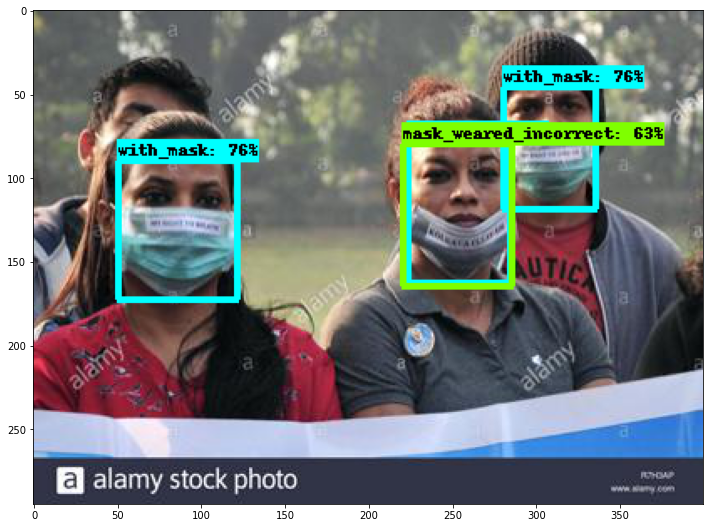

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

# TEST_IMAGE_PATHS = glob.glob('/content/test/test/*.jpg')
image_path = '/content/drive/MyDrive/data/images/maksssksksss29.jpg'
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()